# Chapter 4: LMS-Based Algorithms

## Imports 

In [1]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import SignError, LMSNewton
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Problem 8

x(k) is obtained after passing n(k) through the following filter 

$$H_{in}(z) = \frac{X(z)}{N(z)} = \frac{1}{1-0.9z^{-1}}$$

Consequently

$$x(k) = 0.9x(k-1)+n(k)$$

According to Equation (2.83)

$$r(l) = \frac{(0.9)^{|l|}}{1-(-0.9)^2}\sigma_{n_x}^2$$

For $N+1$ = 12 coefficients, $tr[R] = (N+1)r(0) = 31.578$. For the sign-error algorithm, the condition that guarantees both convergence and low-variance in the steady-state is given by 
	
$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} \sqrt{\frac{\pi \xi (k)}{2}} $$

By considering $\xi(k) = \xi_{min} = \sigma_n^2$ (Most strict scenario for $\mu$ considering the minimum measurement error) we have 

$$ 0 < \mu < 0.0182 $$


In [4]:
output_filepath = './Outputs/Chap_4/Exercise_8/'
model_name = 'SignError'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))*(np.sqrt(np.pi*mse_min_estimate/2))
print ('mu_max: ', mu_max)

Trace: 31.57894736842106
mu_max:  0.0012550536442419034


### (b)

$$ H(z) = \frac{D(z)}{X(z)} = \frac{1-z^{-12}}{1+z^{-1}} $$

$$ d(k) = -d(k-1)+x(k)-x(k-12)  $$

In [42]:
K = 10000 # number of iterations (signal length)
factor = 10
mu = mu_max/factor

def G(x): # Input signal filter before unknown system
        y = np.zeros(len(x), dtype = complex)
        for ii in range(len(x)):
            y[ii] = .9*y[ii-1] + x[ii]
        return y
    
def H(x): # Unknown system 
    postfixed_x = np.append(x,np.zeros(12,dtype = complex))
    postfixed_y = np.zeros(len(postfixed_x), dtype = complex)
    for ii in range(0,len(postfixed_x)):
        postfixed_y[ii] = (-1)*postfixed_y[ii-1] + postfixed_x[ii] - postfixed_x[ii-12]
    y = postfixed_y[:len(x)]
    return y

def run_problem_8(K, mu, model='SignError'):
    d = np.zeros([K]) # Desired signal        
    x = np.zeros([K])
    n_x = np.random.uniform(-1, 1, K)
    n_x = (n_x-n_x.mean())/np.sqrt(n_x.var()/sigma_x2) # Input signal 
    
    x = G(n_x) # Adaptive Filter input signal   
    n = np.random.uniform(-1, 1, K)
    n = (n-n.mean())/np.sqrt(n.var()/sigma_n2) # Measurement noise   
    d = H(x)    
    d = d + n
        
    # Fitting algorithm
    if model == 'SignError':
        from adaptive_filtering.lms import SignError
        model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    elif model == 'NLMS':
        from adaptive_filtering.lms import NLMS
        model = NLMS(step=mu, filter_order=N-1, init_coef=np.ones([N]), gamma=1e-10)
    elif model == 'LMSNewton':
        from adaptive_filtering.lms import LMSNewton
        model = LMSNewton(step=mu, filter_order=N-1, init_coef=np.ones([N]), init_inv_rx_hat=None)
    elif model == 'TransformDomainDCT':
        from adaptive_filtering.lms import TransformDomainDCT
        model = TransformDomainDCT(step=mu, filter_order=N-1, init_power=0, init_coef=np.ones([N]), alpha=.01, gamma=1e-12)
    
    model.fit(d, x)  
    
    return model, n, x

model, n, x = run_problem_8(K, mu, 'TransformDomainDCT')
print (model)

TransformDomainDCT(step=0.003166666666666666, filter_order=11, alpha=0.01, gamma=1e-12, init_power=0)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


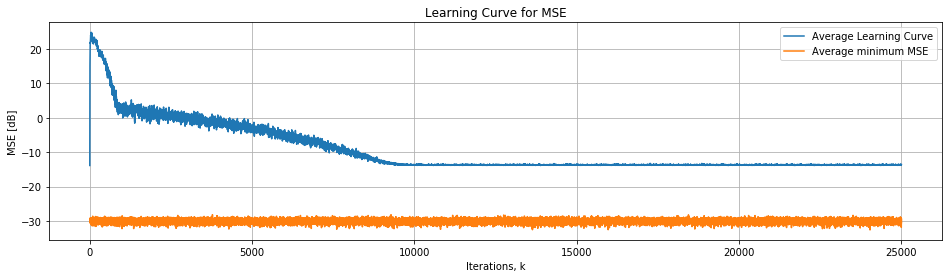

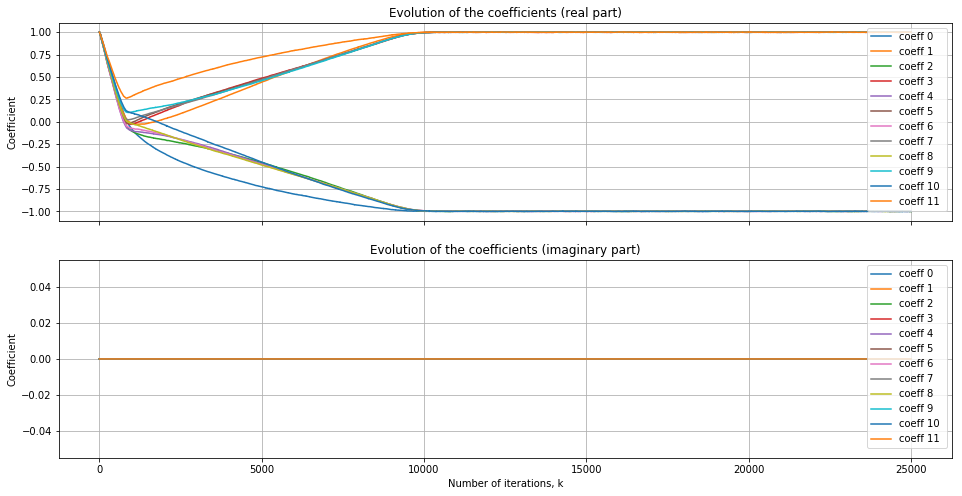

In [9]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 25000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

### (c)

mu_max/2: M_theoretical = 0.7853981633974483


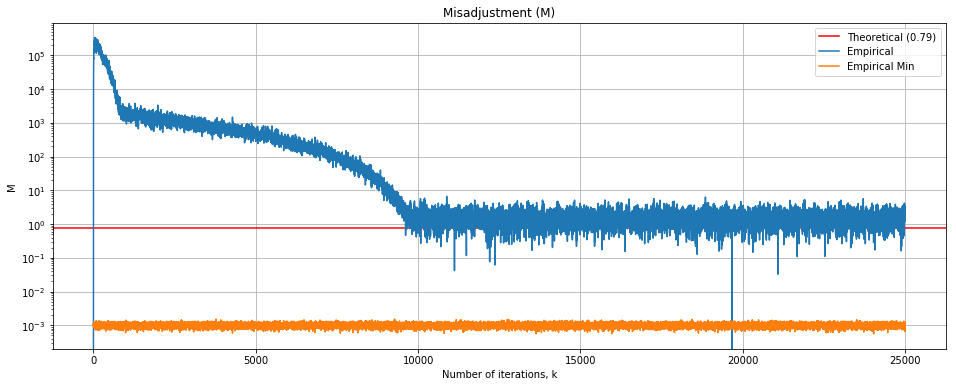

In [10]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(factor)+'.jpg', bbox_inches = 'tight')

### (d)

/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


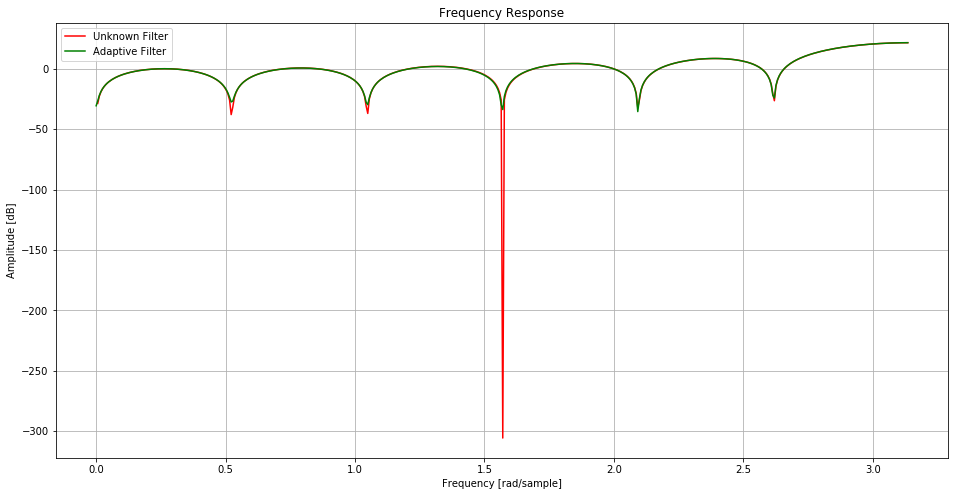

In [15]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
# ax.plot(wf_o, 20 * np.log10(abs(h_o)), 'b', label='Wiener Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(factor), bbox_inches = 'tight')

## Problem 22

** For the setup described in problem 8, choose an appropriate $\mu$ and run the LMS-Newton algorithm$$.

According to Equation (2.83)

$$r(l) = \frac{(0.9)^{|l|}}{1-(-0.9)^2}\sigma_{n_x}^2$$

For $N+1$ = 12 coefficients, $tr[R] = (N+1)r(0) = 31.578$. By setting the following condition
	
$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} = 0.03167$$

We choose $\mu = 0.01$



In [16]:
output_filepath = './Outputs/Chap_4/Exercise_22/'
model_name = 'LMSNewton'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)
mu = 0.01
print ('mu: ', mu)

Trace: 31.57894736842106
mu_max:  0.03166666666666666
mu:  0.01


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


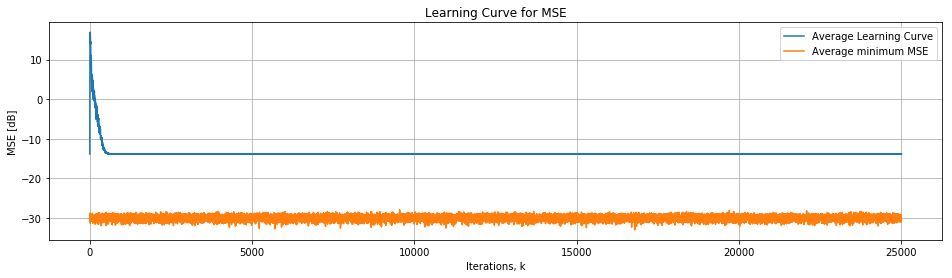

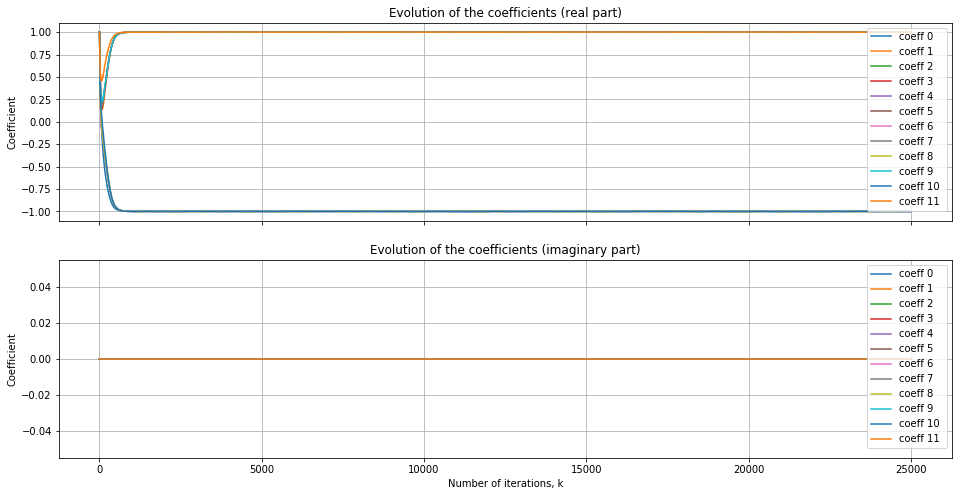

In [18]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 25000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

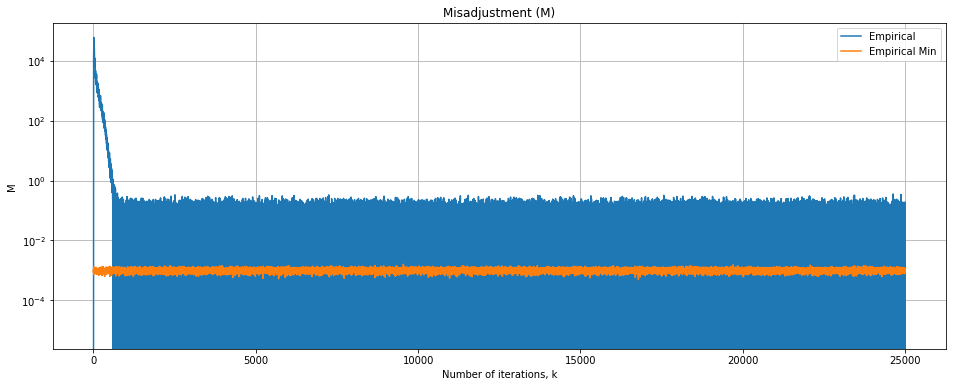

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment.jpg', bbox_inches = 'tight')

### (b) 

/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


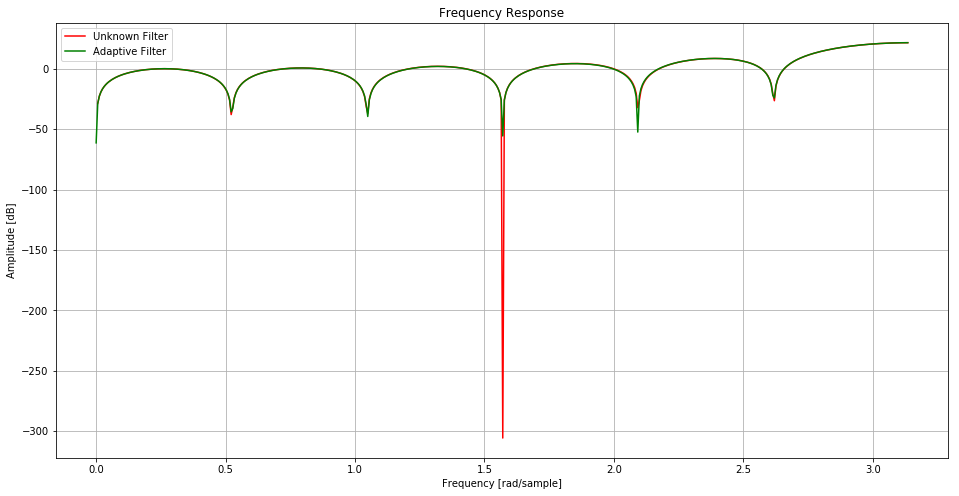

In [20]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response.jpg', bbox_inches = 'tight')

## Problem 23

For the NLMS algorithm, 

$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} = 0.03167$$

In [21]:
output_filepath = './Outputs/Chap_4/Exercise_23/'
model_name = 'NLMS'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)

Trace: 31.57894736842106
mu_max:  0.03166666666666666


### (b)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 18.8 µs


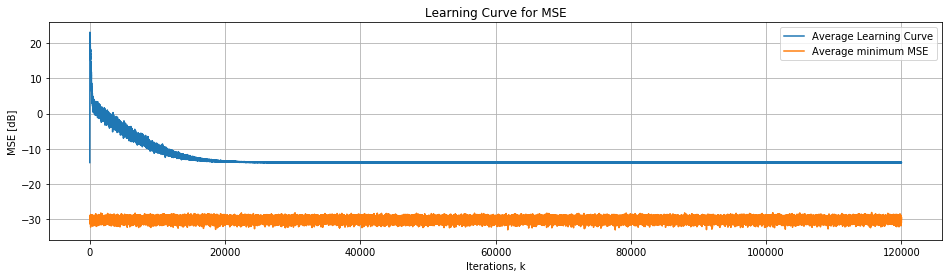

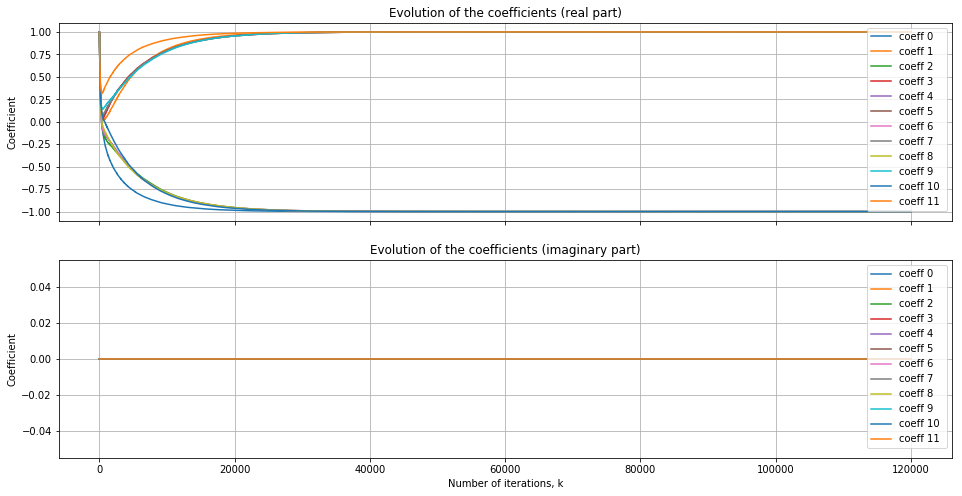

In [36]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 120000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

### (c)

mu_max/2: M_theoretical = 19.816636488030053


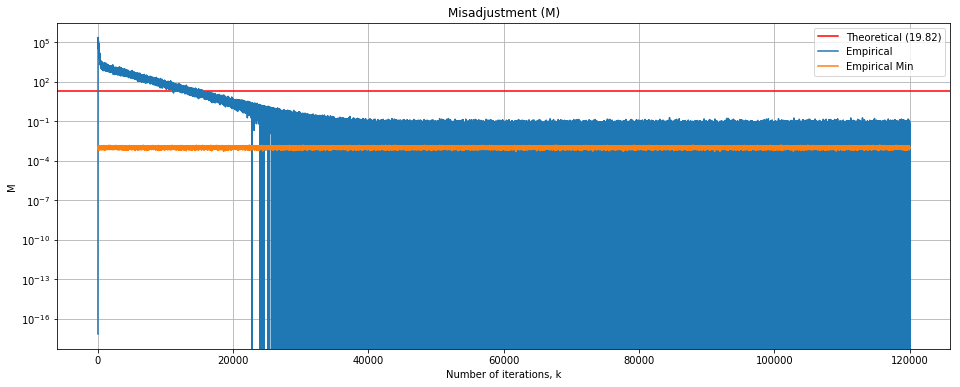

In [37]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(factor)+'.jpg', bbox_inches = 'tight')

### (d)

/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


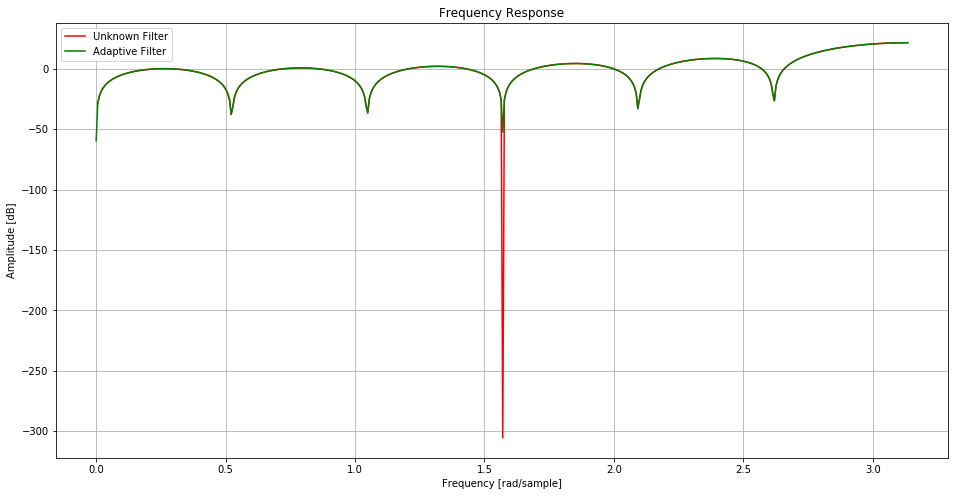

In [38]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(factor), bbox_inches = 'tight')

## Problem 24

Repeat problem 8 using the transform-domain LMS algorithm with DFT. Compare the results with those obtained with the standard LMS algorithm.

## Problem 25

Repeat problem 8 using the Affine-projection algorithm

## Problem 26

Repeat problem 8 using the transform-domain LMS algorithm with DCT. 

In [ ]:
output_filepath = './Outputs/Chap_4/Exercise_24/'
model_name = 'TransformDomainDCT'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)

## (b)

In [55]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 120000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 10
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 32.2 µs


MemoryError: 

## (c)

mu_max/5: M_theoretical = 7.92665459521202


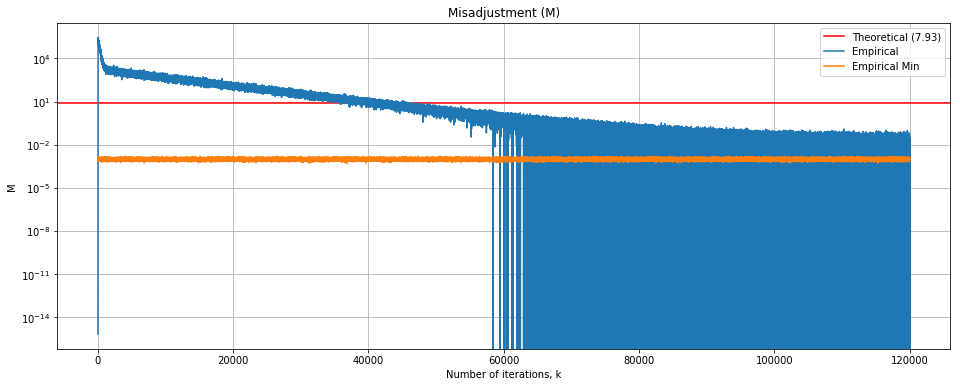

In [53]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(factor)+'.jpg', bbox_inches = 'tight')

## (d)

/home/jaoguedes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


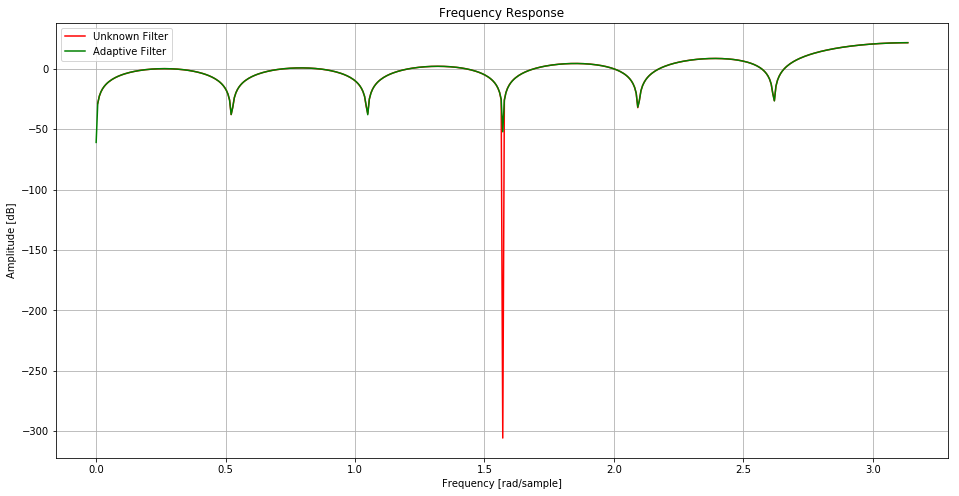

In [54]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(factor), bbox_inches = 'tight')

## Problem 27

For the input signal described in problem 8, derive the autocorrelation matrix of order one ($2 \times 2$). Apply the DCT and the normalization to $\textbf{R}$ in order to generate $\hat{\textbf{R}} = \Sigma^{-2}\textbf{R}\textbf{T}^T$. Compare the eigenvalue spreads of $\textbf{R}$ and $\hat{\textbf{R}}$.} 

The input signal $x(k)$ is given by 

$$x(k) = g(k)*n_x(k)$$

where $n_x(k)$ is a white noise with variance $\sigma_x^2 = 0.5$ and $g(k)$ is the impulse response of the following filter 

$$G(z)  = \frac{z}{z-0.9}$$

Consequently, $x(k)$ can be expressed as 

$$x(k) = 0.9x(k-1) + n_x(k)$$ 

According to Equation 2.83, yields the following autocorrelation function: 

$$r(l) = \frac{0.9^{|l|}}{1-0.9^2} \sigma_x^2 $$

where we have $r(0) = 2.63$ and $r(1) = 2.37$. In the case of a $2 \times 2$ autocorrelation matrix, we have 



In [ ]:
from scipy.linalg import toeplitz
N = 2
r = lambda l, sigma_x2: (sigma_x2*.9**abs(l))/(1-0.9**2)
R = toeplitz([r(l, sigma_x2) for l in np.arange(N)])
print ('R: ', R)
print ('eig: ', np.linalg.eigvals(R))

\begin{equation*}
	\begin{split}
		\textbf{R} &= 		
		\begin{bmatrix} 
			r(0) & r(1) \\
			r(1) & r(0) 
		\end{bmatrix} \\
		&= 		
		\begin{bmatrix} 
			2.63 & 2.37 \\
			2.37 & 2.63 
		\end{bmatrix} 
	\end{split}
\end{equation*}

with eigenvalues $\lambda = \{5.000, 0.263\} \rightarrow \frac{\lambda_{max}}{\lambda_{min}} = 19.000$. 

Concurrently, for a $2 \times 2$ matrix, the DCT transform matrix is given by 

$$\textbf{T} = \begin{bmatrix} 
0.707 & 0.707 \\
0.707 & -0.707 
\end{bmatrix}$$

whereas $\Sigma^{-2}$  is given by

\begin{equation*}
	\begin{split}
		\Sigma^{-2} = \begin{bmatrix} 
			(\gamma + \sigma_0^2(k))^{-1} & 0 \\
			0 & (\gamma + \sigma_1^2(k))^{-1} 
		\end{bmatrix}
	\end{split}
\end{equation*}

with $\sigma_i^2(k) = \alpha s_i^2(k) + (1-\alpha)\sigma_i^2(k-1)$ and $s(k) = \textbf{T}x(k)$

In [ ]:
def getDCTMatrix(size):
    '''Calculate the square DCT transform matrix. Results are 
    equivalent to Matlab dctmtx(n) with 64 bit precision.'''
    DCTmx = np.array(range(size),np.float64).repeat(size).reshape(size,size)
    DCTmxT = np.pi * (DCTmx.transpose()+0.5) / size
    DCTmxT = (1.0/np.sqrt( size / 2.0)) * np.cos(DCTmx * DCTmxT)
    DCTmxT[0] = DCTmxT[0] * (np.sqrt(2.0)/2.0)
    return DCTmxT
getDCTMatrix(N+2)